In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_curve
from sklearn import ensemble
from sklearn import linear_model
from sklearn import tree
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from textblob import TextBlob,Word
from nltk.corpus import words

%matplotlib inline

In [2]:
data = pd.read_csv("files/tweet_filtered_2.csv")

In [3]:
data.shape

(110482, 4)

In [4]:
data.isnull().sum()

Unnamed: 0              0
Unnamed: 0.1            0
tweet                   0
filtered_sentence    1142
dtype: int64

In [5]:
data.dropna(inplace=True)

In [6]:
data.shape

(109340, 4)

 Filter sentences if it has minimum of 5 words
 
 
 

In [7]:
data["filtered_sentence"]=data.filtered_sentence.apply(lambda x: x if(len(x.split())>4) else None)

In [8]:
data.isnull().sum()

Unnamed: 0              0
Unnamed: 0.1            0
tweet                   0
filtered_sentence    5369
dtype: int64

In [10]:
data.dropna(inplace=True)
data.shape

(103971, 4)

Filter the unique sentences

In [11]:
tweets = data.filtered_sentence.unique()
tweets.shape

(56573,)

Takes only the sentences

In [12]:
tweets= pd.DataFrame(data=tweets,columns=['text'])

In [13]:
pol = lambda x:TextBlob(x).sentiment.polarity
sub = lambda x:TextBlob(x).sentiment.subjectivity

In [14]:
tweets['polarity']=tweets.text.apply(pol)
tweets['subjectivity']=tweets.text.apply(sub)

In [15]:
pol_er= lambda x: 1 if(x!=0) else None
tweets["pol_zr"]=tweets.polarity.apply(pol_er)

In [16]:
tweets.isnull().sum()

text                0
polarity            0
subjectivity        0
pol_zr          16516
dtype: int64

Remove the Polarity zero sentences

In [18]:
tweets.dropna(inplace=True)

In [19]:
sent = lambda x: 1 if(x>0) else 0

In [20]:
tweets["sentiment"]=tweets.polarity.apply(sent)

In [21]:
sub_er= lambda x: 1 if(x>0) else None
tweets["sub_zr"]=tweets.subjectivity.apply(sub_er)

In [22]:
tweets.isnull().sum()

text              0
polarity          0
subjectivity      0
pol_zr            0
sentiment         0
sub_zr          155
dtype: int64

Remove the subjectivity zero sentences

In [24]:
tweets.dropna(inplace=True)

In [25]:
tweets.sentiment.value_counts()

1    26786
0    13116
Name: sentiment, dtype: int64

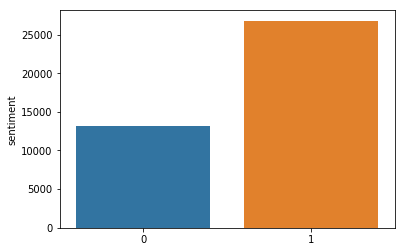

In [26]:
sns.barplot(x=[1,0],y=tweets.sentiment.value_counts(),data=tweets)

In [27]:
data_base=tweets.text.tolist()
total_words=[]                      # All words
for i in data_base:
    for j in i.split():
        j=j.lower()
        total_words.append(j)
print("Total words = ",len(total_words))

Total words =  720969


In [28]:
w_c=pd.DataFrame(data=total_words,columns=["words"])
w_c.shape

(720969, 1)

In [29]:
w_c_filtered=w_c[w_c["words"].map(w_c["words"].value_counts())>10]
w_c_filtered.shape

(632429, 1)

In [30]:
w_c_filtered =pd.DataFrame(data= w_c_filtered["words"].unique() , columns=["words"])
w_c_filtered.shape

(6440, 1)

In [31]:
all_words=w_c_filtered.words.tolist()

In [32]:
print("All words = ",len(all_words))
corp=words.words()
flt_wrds=[w for w in all_words if w in corp]
print("Meaningful english words = ",len(flt_wrds))   

All words =  6440
Meaningful english words =  4069


In [33]:
flt_wrd_set=set(flt_wrds)
wrd_chk = lambda x:1 if len((set(x.split()).intersection(flt_wrd_set)))>=1 else None

In [34]:
tweets["word_chk"]=tweets.text.apply(wrd_chk)

In [35]:
tweets.isnull().sum()

text              0
polarity          0
subjectivity      0
pol_zr            0
sentiment         0
sub_zr            0
word_chk        793
dtype: int64

In [36]:
tweets.dropna(inplace=True)

## Word count vector represent and model training - - - - - -

In [37]:
word_vector=[]
for i in tweets.text:
    i=i.lower()
    mat=[i.count(j) for j in flt_wrds]
    word_vector.append(mat)

In [38]:
X_count_vect = pd.DataFrame(word_vector,columns=flt_wrds)
X_count_vect.shape

(39109, 4069)

In [39]:
y=tweets.sentiment

In [40]:
X_train,X_test,y_train,y_test=train_test_split(X_count_vect,y,test_size=0.25,random_state=7)

In [41]:
def reports(ytrue,predicted):
    print("Accuracy : {}".format(metrics.accuracy_score(ytrue,predicted)))
    print("Precision : {}".format(metrics.precision_score(ytrue,predicted)))
    print("Recall : {}".format(metrics.recall_score(ytrue,predicted)))
    print("Logloss : {}".format(metrics.log_loss(ytrue,predicted)))
    print("AUC : {}".format(metrics.roc_auc_score(ytrue,predicted)))
    print("Confusion Matrix : \n{}".format(metrics.confusion_matrix(ytrue,predicted)))

In [42]:
def all_models_report():
    
    global X_train
    global y_train
    global X_test
    global y_test
    
                # Random Forest Model
    
    
    rfst=ensemble.RandomForestClassifier(n_estimators=10)
    rfst.fit(X_train,y_train)
    rfst_pred =rfst.predict(X_test)
    print("\n\nFor Random Forest\n")
    reports(y_test,rfst_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test,rfst_pred)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.suptitle('AUC-ROC Curve', fontsize=20)
    plt.xlabel('False positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    
    
    
    
                # Decision Tree Model
    
    dst = tree.DecisionTreeClassifier()
    dst.fit(X_train,y_train)
    dst_pred = dst.predict(X_test)
    print("\n\nFor Decision Tree\n")
    reports(y_test,dst_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test,dst_pred)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.suptitle('AUC-ROC Curve', fontsize=20)
    plt.xlabel('False positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    
    
    
                    # Logistic Regression Model
    
    lgs = linear_model.LogisticRegression()
    lgs.fit(X_train,y_train)
    lgr_pred=lgs.predict(X_test)
    print("\n\nFor Logistic Regression\n")
    reports(y_test,lgr_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test,lgr_pred)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.suptitle('AUC-ROC Curve', fontsize=20)
    plt.xlabel('False positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    
    
    
    
                    #  Gaussian Naive Bayes Model
    
    clf1= GaussianNB()
    clf1.fit(X_train,y_train)
    y_pred_gnb=clf1.predict(X_test)
    print("\n\nFor Gaussian Naive Bayes : \n")
    reports(y_test,y_pred_gnb)
    
    fpr, tpr, thresholds = roc_curve(y_test,y_pred_gnb)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.suptitle('AUC-ROC Curve', fontsize=20)
    plt.xlabel('False positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    
    
    
    
                # Multinomial Naive Bayes Model
    
    clf2= MultinomialNB()
    clf2.fit(X_train,y_train)
    y_pred_mnb=clf2.predict(X_test)
    print("\n\nFor Multinomial Naive Bayes : \n")
    reports(y_test,y_pred_mnb)
    
    fpr, tpr, thresholds = roc_curve(y_test,y_pred_mnb)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.suptitle('AUC-ROC Curve', fontsize=20)
    plt.xlabel('False positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()



For Random Forest

Accuracy : 0.8030272039271835
Precision : 0.8274204946996466
Recall : 0.892514102759567
Logloss : 6.8032992068991875
AUC : 0.7566018789659903
Confusion Matrix : 
[[1998 1221]
 [ 705 5854]]


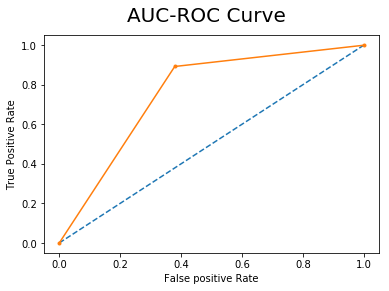



For Decision Tree

Accuracy : 0.7901411331560646
Precision : 0.8474942174248266
Recall : 0.8379326116786096
Logloss : 7.248349352036734
AUC : 0.7653471694615477
Confusion Matrix : 
[[2230  989]
 [1063 5496]]


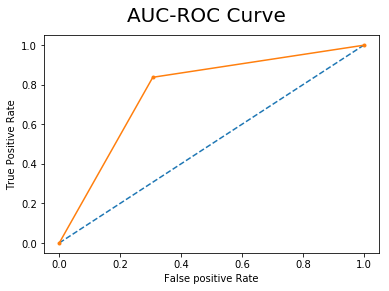

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




For Logistic Regression

Accuracy : 0.8916956432808345
Precision : 0.9094699225729601
Recall : 0.9312395182192408
Logloss : 3.7407496786099386
AUC : 0.8711804922565606
Confusion Matrix : 
[[2611  608]
 [ 451 6108]]


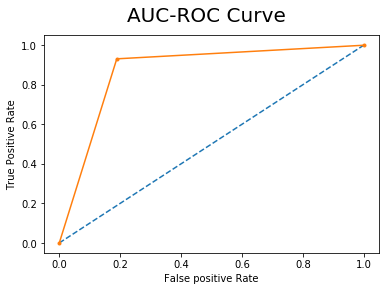



For Gaussian Naive Bayes : 

Accuracy : 0.5840662712211087
Precision : 0.8509859154929578
Recall : 0.46058850434517457
Logloss : 14.365885312450638
AUC : 0.6481258769007638
Confusion Matrix : 
[[2690  529]
 [3538 3021]]


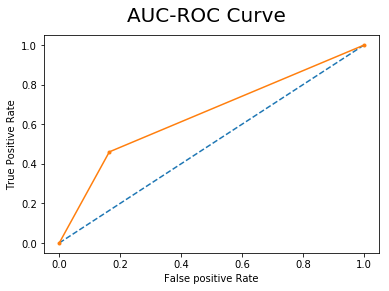



For Multinomial Naive Bayes : 

Accuracy : 0.8006749846594395
Precision : 0.8580304442373408
Recall : 0.842201555115109
Logloss : 6.884516877248122
AUC : 0.7791312217948952
Confusion Matrix : 
[[2305  914]
 [1035 5524]]


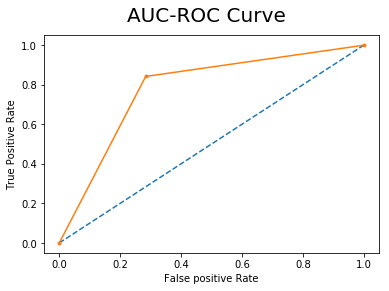

In [43]:
all_models_report()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




For Logistic Regression

Accuracy : 0.8916956432808345
Precision : 0.9094699225729601
Recall : 0.9312395182192408
Logloss : 3.7407496786099386
AUC : 0.8711804922565606
Confusion Matrix : 
[[2611  608]
 [ 451 6108]]


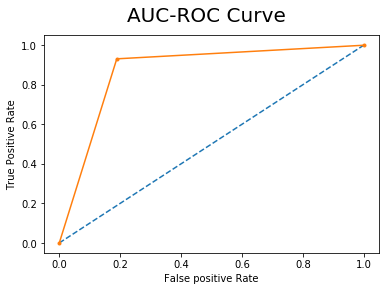

In [44]:
lgs = linear_model.LogisticRegression()
lgs.fit(X_train,y_train)
lgr_pred=lgs.predict(X_test)
print("\n\nFor Logistic Regression\n")
reports(y_test,lgr_pred)

fpr, tpr, thresholds = roc_curve(y_test,lgr_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.suptitle('AUC-ROC Curve', fontsize=20)
plt.xlabel('False positive Rate')
plt.ylabel('True Positive Rate')
plt.show()